# LSTM 

### GDP forecast

In [1]:
from numpy import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


2022-09-01 16:07:24.080668: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-01 16:07:24.085141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 16:07:24.085158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


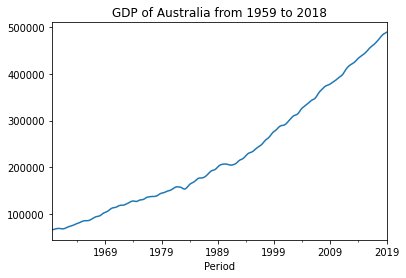

In [2]:

data = pd.read_csv("AUD.csv", 
                    parse_dates=["Period"],
                    index_col="Period")

#covert arguments to datatime
data.loc[:,'GDP'].plot(label='Observed', color='tab:blue')
plt.title('GDP of Australia from 1959 to 2018')
plt.show()

Obtaining the Robust Scale factor from training data

In [3]:
# Split data

train_size = int(len(data) * 0.8)
train = data[0:train_size]
print(len(train))

data1 = data.dropna()
# normalize the dataset
GDP_scaler = RobustScaler()
GDP_scaler = GDP_scaler.fit(train[['GDP']])

data1['GDP'] = GDP_scaler.transform(data1[['GDP']])

191


We need to create the dataset to feed in LSTM.

In [4]:
def create_dataset(X,y,time_steps):
    Xs, ys = [],[]
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
time_steps = 2
X, y = create_dataset(data1, data1['GDP'], time_steps)
X_train, X_test = X[0:train_size-time_steps,:,:], X[train_size-time_steps:,:,:]
y_train, y_test = y[0:train_size-time_steps], y[train_size-time_steps:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(189, 2, 1) (189,)
(48, 2, 1) (48,)


#### Building a LSTM model for GDP

In [6]:
# Building a model
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.LSTM(20, activation='tanh',recurrent_activation='sigmoid', return_sequences=True),
     # By default, LSTM layers in Keras only returns the final output. To ensure
     # them return one output per time step, you must set  return_sequence=True.
     # This is to ensure output is 3D dimension
    keras.layers.LSTM(20, activation='tanh',recurrent_activation='sigmoid'),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, 
epochs=100, validation_split=0.1, 
callbacks=keras.callbacks.EarlyStopping(patience=10),
shuffle=False)


Epoch 1/100


2022-09-01 16:07:54.133128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 16:07:54.133152: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 16:07:54.133170: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valid-cl): /proc/driver/nvidia/version does not exist
2022-09-01 16:07:54.133399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6/6 [==============================] - 2s 118ms/step - loss: 0.3320 - val_loss: 2.3251
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3191 - val_loss: 2.2587
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.3100 - val_loss: 2.1867
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3010 - val_loss: 2.1107
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2916 - val_loss: 2.0297
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2817 - val_loss: 1.9421
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2709 - val_loss: 1.8460
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2591 - val_loss: 1.7397
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.2461 - val_loss: 1.6214
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 1.4898
Epoch 11/100
6/6 [===================

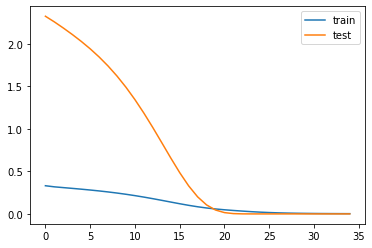

In [7]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


#### Prediction

In [8]:
# making prediction
y_pred = model.predict(X_test)

# inverting predictions

y_train_inv = GDP_scaler.inverse_transform(y_train.reshape(1, -1)) #transforming y_train to column vector
y_test_inv = GDP_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = GDP_scaler.inverse_transform(y_pred.reshape(1,-1))

2/2 [==============================] - 0s 3ms/step


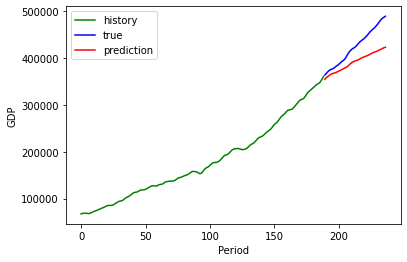

In [9]:
# plotting

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), 'b', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GDP')
plt.xlabel('Period')
plt.legend()
plt.show();


 Calculating Root Mean squared errors

In [10]:
# calculate root mean squared error
RMSE = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Score: %.2f RMSE' % (RMSE))

Score: 37500.64 RMSE


### Recursive forecast

In [11]:

# Recursive forecast

def recursive_forecasts(model, testY, trainX):
    forecasts = list()
    for i in range(len(testY)):
        X = trainX[-1:,:]
        forecast = model.predict(X)
        # Update training data using the latest prediction
        temp= np.append(forecast.flatten(),trainX[-1:,0:-1].flatten())
        temp1 = np.append(np.squeeze(trainX),np.reshape(temp,[1,trainX.shape[1]]),axis=0)
        trainX = np.reshape(temp1,[trainX.shape[0]+1,trainX.shape[1],1])
        forecasts.append(forecast)
    return np.array(forecasts)

In [12]:
y_recursive = recursive_forecasts(model,y_test,X_train)


1/1 [==============================] - 0s 13ms/step


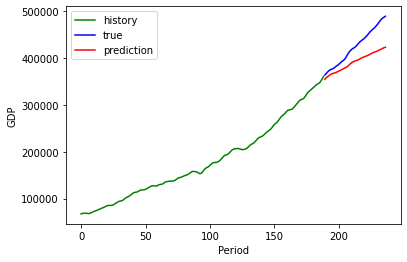

In [13]:
y_recursive_inv = GDP_scaler.inverse_transform(y_recursive.reshape(1,-1))
# plotting

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), 'b', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GDP')
plt.xlabel('Period')
plt.legend()
plt.show();

#### Building LSTM for $\Delta GDP$

In [14]:
data['GDP_diff']= data['GDP'].diff()
data1 = data.dropna()

In [15]:
# Split data
train = data1.iloc[0:train_size-1]
print(len(train))


## normalize the dataset
GDP_diff_scaler = RobustScaler()
GDP_diff_scaler = GDP_diff_scaler.fit(train[['GDP_diff']])

data1['GDP_diff'] = GDP_diff_scaler.transform(data1[['GDP_diff']])

190


/tmp/ipykernel_325975/2920899813.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['GDP_diff'] = GDP_diff_scaler.transform(data1[['GDP_diff']])


In [16]:
time_steps = 2
X,y = create_dataset(data1[['GDP_diff']], data1.GDP_diff, time_steps)
X_train, X_test = X[0:train_size-time_steps-1,:,:], X[train_size-time_steps-1:,:,:]
y_train, y_test = y[0:train_size-time_steps-1], y[train_size-time_steps-1:]
print(len(X_train),len(X_test))

188 48


In [17]:
# Building a LSTM model
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.LSTM(20, activation='tanh',recurrent_activation='sigmoid', return_sequences=True), # use this for stacked LSTM
    keras.layers.LSTM(20, activation='tanh',recurrent_activation='sigmoid'),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, 
epochs=100, validation_split=0.1, 
callbacks=keras.callbacks.EarlyStopping(patience=10),
shuffle=False)

Epoch 1/100
6/6 [==============================] - 2s 89ms/step - loss: 0.5217 - val_loss: 1.1978
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5088 - val_loss: 1.1739
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4985 - val_loss: 1.1471
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4881 - val_loss: 1.1183
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4771 - val_loss: 1.0873
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4653 - val_loss: 1.0536
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4525 - val_loss: 1.0167
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4386 - val_loss: 0.9766
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4237 - val_loss: 0.9335
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4081 - val_loss: 0.8882
Epoch 11/100
6/6 [=========

In [18]:
# making prediction
y_pred = model.predict(X_test)

# inverting predictions

y_train_inv = GDP_diff_scaler.inverse_transform(y_train.reshape(1, -1)) #transforming y_train to column vector
y_test_inv = GDP_diff_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = GDP_diff_scaler.inverse_transform(y_pred.reshape(1,-1))

2/2 [==============================] - 0s 3ms/step


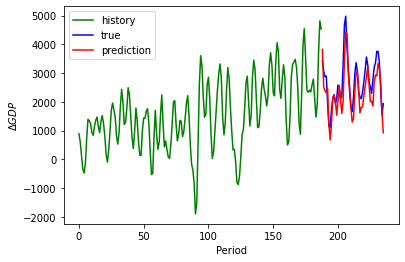

In [19]:
# plotting

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), 'b', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('$\Delta GDP$')
plt.xlabel('Period')
plt.legend()
plt.show();

Converting back to GDP level

In [20]:
raw_GDP = data["GDP"].values
y_train_inv = y_train_inv.flatten() + raw_GDP[time_steps:train_size-1]
y_test_inv = y_test_inv.flatten() + raw_GDP[train_size-1:-1,]
y_pred_inv = y_pred_inv.flatten() +raw_GDP[train_size-1:-1,]


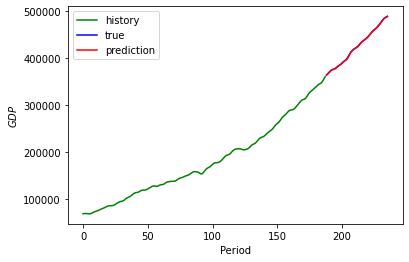

In [21]:

plt.plot(np.arange(0, len(y_train)), y_train_inv, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, 'b', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, 'r', label="prediction")
plt.ylabel('$ GDP$')
plt.xlabel('Period')
plt.legend()
plt.show();


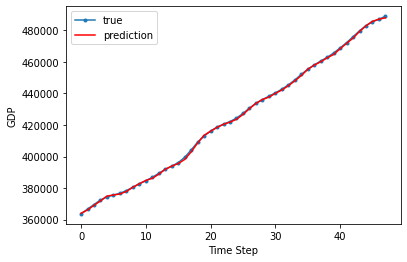

In [22]:
plt.plot(y_test_inv, marker='.', label="true")
plt.plot(y_pred_inv, 'r', label="prediction")
plt.ylabel('GDP')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Calculating Root Mean Squared Error

In [179]:
# calculate root mean squared error
RMSE = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Score: %.2f RMSE' % (RMSE))

Score: 523.85 RMSE


### Building Bidirectional LSTM model

In [24]:
# Building a Bidirectoral LSTM model
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential()
forward_layer = keras.layers.LSTM(10, return_sequences=True)
backward_layer = keras.layers.LSTM(10, activation='relu', return_sequences=True,
                       go_backwards=True)

model.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer,
))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(10)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, 
epochs=100, validation_split=0.1, 
callbacks=keras.callbacks.EarlyStopping(patience=10),
shuffle=False)

Epoch 1/100
6/6 [==============================] - 4s 135ms/step - loss: 0.5156 - val_loss: 1.2155
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5022 - val_loss: 1.1903
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4888 - val_loss: 1.1632
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4775 - val_loss: 1.1355
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4665 - val_loss: 1.1063
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4589 - val_loss: 1.0762
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4443 - val_loss: 1.0454
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4348 - val_loss: 1.0135
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4196 - val_loss: 0.9805
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4052 - val_loss: 0.9459
Epoch 11/100
6/6 [=======

2/2 [==============================] - 1s 3ms/step


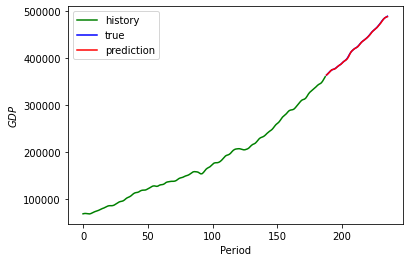

In [25]:
# making prediction
y_pred = model.predict(X_test)

# inverting predictions

y_train_inv = GDP_diff_scaler.inverse_transform(y_train.reshape(1, -1)) #transforming y_train to column vector
y_test_inv = GDP_diff_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = GDP_diff_scaler.inverse_transform(y_pred.reshape(1,-1))


# converting back to the level

y_train_inv = y_train_inv.flatten() + raw_GDP[time_steps:train_size-1]
y_test_inv = y_test_inv.flatten() + raw_GDP[train_size-1:-1,]
y_pred_inv = y_pred_inv.flatten() +raw_GDP[train_size-1:-1,]


plt.plot(np.arange(0, len(y_train)), y_train_inv, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, 'b', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, 'r', label="prediction")
plt.ylabel('$ GDP$')
plt.xlabel('Period')
plt.legend()
plt.show();